In [1]:
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import networkx as nx
import community
import pandas as pd

import numpy as np
import json


In [3]:
import collections

In [4]:
from networkx.algorithms.community import greedy_modularity_communities


In [5]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file, test_kruskal


In [6]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.lines as lines

font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [9]:
df = pd.read_csv("../../data/prisoners_dilemma_articles_meta_data_clean.csv")


In [10]:
periods = np.sort(df["date"].unique())
periods = periods[~np.isnan(periods)]
periods = periods[1:]

 Collaborativeness 
---------------------------

In [11]:
graph = nx.read_gml("../../data/networks/pd_new_graph.gml")

Illustrating co-authors network
------------------------

**Use Gephi**

Network Metrics
-----------------------

In [12]:
number_edges = nx.number_of_edges(graph)
number_nodes = nx.number_of_nodes(graph)


In [13]:
for filename, metric in zip(["pd_edges.txt", "pd_unique_authors.txt"],
                            [number_edges, number_nodes]
):
    write_to_file(filename=filename, metric=metric)


In [14]:
def fix_names_for_table(name):
    name = name.title()
    return name



Collaborative Behaviour
-----------------------------

In [15]:
def collaborative_metrics_of_graph(graph):
    """
    Returns the following metrics:
    - number of nodes
    - number of edges
    - number of isolated authors
    - percentage of isolated authors
    - number of connected components
    - size of the largest connected component
    - average degree
    - clustering coefficients
    - modularity
    """
    num_nodes = nx.number_of_nodes(graph)
    num_edges = nx.number_of_edges(graph)
    isolated_nodes = len(list(nx.isolates(graph)))
    percentage_isolated_nodes = np.round(isolated_nodes / num_nodes, 3) * 100
    number_connected_components = nx.number_connected_components(graph)
    size_of_largest_cc = len(max(nx.connected_components(graph), key=len))

    degree_distribution = sorted([d for n, d in graph.degree()], reverse=True)
    av_degree = np.round(np.mean(degree_distribution), 3)

    clustering_coeff = round(nx.average_clustering(graph), 3)

    try:
        number_of_communities = len(list(greedy_modularity_communities(graph)))
    except ZeroDivisionError:
        number_of_communities = "-"

    communities = community.best_partition(graph)
    try:
        modularity = community.modularity(partition=communities, graph=graph)
    except ValueError:
        modularity = "-"

    metrics = {
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "# Isolated nodes": isolated_nodes,
        "% Isolated nodes": round(percentage_isolated_nodes, 3),
        "# Connected components": number_connected_components,
        "Size of largest component": size_of_largest_cc,
        "Av. degree": av_degree,
        "Clustering coeff": clustering_coeff,
        "# Communities": number_of_communities,
        "Modularity": modularity,
    }

    return metrics, degree_distribution


**Network Metrics**

In [16]:
metrics = collaborative_metrics_of_graph(graph)[0]


In [17]:
metrics


{'# Nodes': 4221,
 '# Edges': 7642,
 '# Isolated nodes': 338,
 '% Isolated nodes': 8.0,
 '# Connected components': 1157,
 'Size of largest component': 796,
 'Av. degree': 3.621,
 'Clustering coeff': 0.666,
 '# Communities': 1177,
 'Modularity': 0.9652643783671604}

In [18]:
degree_dstrs = collaborative_metrics_of_graph(graph)[1]

In [19]:
for key in metrics:
    filename = key.replace(" ", "_").replace("#", "num").replace("%", "perce") + ".txt"
    write_to_file(filename, metrics[key])


**Analysing clusters**

In [20]:
center_cluster = max(nx.connected_component_subgraphs(graph), key=len)


In [21]:
center_cluster_metrics = collaborative_metrics_of_graph(center_cluster)[0]


In [22]:
center_cluster_degrees = collaborative_metrics_of_graph(center_cluster)[1]



**Tables**

In [23]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]


In [ ]:
auctions_graph = nx.read_gml("../../data/networks/auction_graph.gml")
price_graph = nx.read_gml("../../data/networks/anarchy_graph.gml")

In [ ]:
auction_metrics = collaborative_metrics_of_graph(auctions_graph)[0]
price_metrics = collaborative_metrics_of_graph(price_graph)[0]

**write table**

In [34]:
metrics_table = pd.DataFrame.from_dict([metrics, center_cluster_metrics, auction_metrics, price_metrics])
metrics_table.index = [r"$G$", r"$\bar{G}$", "Auction Games", "Price of Anarchy"]

In [35]:
metrics_table = metrics_table[columns_order]

In [36]:
metrics_table

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
$G$,4221,7642,338,8.0,1157,796,3.621,1177,0.965264,0.666
$\bar{G}$,796,2214,0,0.0,1,796,5.563,29,0.840138,0.773
Auction Games,5362,7861,453,8.4,1469,1348,2.932,1493,0.957238,0.599
Price of Anarchy,1315,1952,165,12.5,406,221,2.969,414,0.964498,0.626


In [37]:
write_to_file(metric=metrics_table.to_latex(), filename="network_comparison.tex")


**Degree Distribution**

In [38]:
max(degree_dstrs)


59

In [39]:
colors = [None, "darkgreen"]
labels = [r'$G$', r'$\bar{G}$']

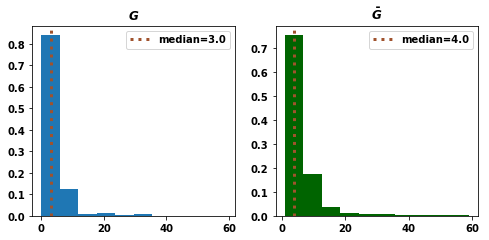

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))

for i, measure in enumerate([degree_dstrs, center_cluster_degrees]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="sienna",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")
    axes[i].set_title(labels[i])

    axes[i].legend();

plt.savefig("../../assets/images/networks_ditributions.pdf")


In [41]:
temp = pd.DataFrame(degree_dstrs)
temp.describe()

,0
count,4221.000000
mean,3.620943
std,4.382903
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,59.000000


Cumulative Graphs
---------

In [42]:
linestyle = [":o", "-.", "--"]


In [43]:
import glob


In [44]:
years = sorted(df.date.unique())

In [47]:
cumulative_graphs = []
for year in years[:-1]:
    cumulative_graphs.append(nx.read_gml(f"../../data/networks/yearly/G_pd_{int(year)}.gml"))


In [48]:
len(cumulative_graphs)

57

In [49]:
cumulative_clusters = [max(nx.connected_component_subgraphs(G), key=len) for G in cumulative_graphs[6:]]


In [50]:
len(cumulative_graphs), len(cumulative_clusters)


(57, 51)

In [51]:
cumulative_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_graphs[6:]
]


In [52]:
cumulative_cluster_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_clusters]


In [53]:
len(cumulative_cluster_metrics)

51

**Tables**

In [54]:
with open("../../assets/periods_dictionary.json") as json_file:
    periods_dictionary = json.load(json_file)

In [120]:
cumulative_table = pd.DataFrame.from_dict(cumulative_metrics).round(3)
cumulative_table = cumulative_table[columns_order]


In [121]:
cumulative_table.head(15)


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
0,11,3,5,45.5,8,2,0.545,8,0.667,0.000
1,14,4,6,42.9,10,2,0.571,10,0.750,0.000
2,27,15,8,29.6,16,5,1.111,16,0.684,0.160
3,29,17,9,31.0,17,6,1.172,17,0.630,0.172
4,32,18,10,31.2,19,6,1.125,19,0.667,0.156
5,43,28,10,23.3,23,6,1.302,23,0.827,0.326
6,49,34,10,20.4,25,6,1.388,25,0.867,0.408
7,52,35,11,21.2,27,6,1.346,27,0.873,0.385
8,54,35,13,24.1,29,6,1.296,29,0.873,0.370
9,54,35,13,24.1,29,6,1.296,29,0.873,0.370


In [122]:
cumulative_table.index = [f"Period {i}" for i in cumulative_table.index]

In [123]:
cumulative_table

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
Period 0,11,3,5,45.5,8,2,0.545,8,0.667,0.000
Period 1,14,4,6,42.9,10,2,0.571,10,0.750,0.000
Period 2,27,15,8,29.6,16,5,1.111,16,0.684,0.160
Period 3,29,17,9,31.0,17,6,1.172,17,0.630,0.172
Period 4,32,18,10,31.2,19,6,1.125,19,0.667,0.156
Period 5,43,28,10,23.3,23,6,1.302,23,0.827,0.326
Period 6,49,34,10,20.4,25,6,1.388,25,0.867,0.408
Period 7,52,35,11,21.2,27,6,1.346,27,0.873,0.385
Period 8,54,35,13,24.1,29,6,1.296,29,0.873,0.370
Period 9,54,35,13,24.1,29,6,1.296,29,0.873,0.370


In [124]:
cumulative_table.describe()

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,681.764706,949.588235,94.372549,27.092157,246.941176,82.921569,1.583725,248.784314,0.911627,0.360882
std,1091.295113,1893.650519,93.952107,10.785228,315.961606,188.097086,0.800257,320.172411,0.088723,0.152346
min,11.000000,3.000000,5.000000,8.000000,8.000000,2.000000,0.545000,8.000000,0.630000,0.000000
25%,64.000000,40.000000,18.000000,19.750000,35.000000,6.000000,1.093000,35.000000,0.884000,0.274000
50%,154.000000,81.000000,60.000000,28.600000,95.000000,6.000000,1.270000,95.000000,0.947000,0.334000
75%,679.500000,539.500000,135.500000,37.050000,323.500000,20.500000,1.583500,323.500000,0.969000,0.415000
max,4221.000000,7642.000000,338.000000,45.500000,1157.000000,796.000000,3.621000,1177.000000,0.987000,0.666000


In [125]:
write_to_file(
    metric=cumulative_table.to_latex(), filename="cumulative_graphs_table.tex"
)


In [126]:
clusters_cum_table = pd.DataFrame.from_dict(cumulative_cluster_metrics).round(3)
clusters_cum_table = clusters_cum_table[columns_order]


In [127]:
write_to_file(
    metric=clusters_cum_table.to_latex(), filename="cumulative_clusters_table.tex"
)


**Centralities**

In [61]:
betweeness = sorted(nx.betweenness_centrality(graph).items(), key=lambda x: x[1], reverse=True)
closeness = sorted(nx.closeness_centrality(graph).items(), key=lambda x: x[1], reverse=True)

In [62]:
betweeness_cluster = sorted(nx.betweenness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)
closeness_cluster = sorted(nx.closeness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)

In [63]:
labels = ['Betweenness', 'Closeness']

In [64]:
tables = []
for i, measure in enumerate([betweeness, closeness, betweeness_cluster, closeness_cluster]):
    table = pd.DataFrame(measure[:10], columns=["Name", labels[int(i % 2)]])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table)     


In [66]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="centralities_pd_graph.tex"
)

**Distributions**

In [67]:
distributions_betweeness = [point[1] for point in betweeness]
distributions_closeness = [point[1] for point in closeness]

In [68]:
distributions_betweeness_cluster = [point[1] for point in betweeness_cluster]
distributions_closeness_cluster = [point[1] for point in closeness_cluster]

In [69]:
colors = ['darkgray', 'darkorange']

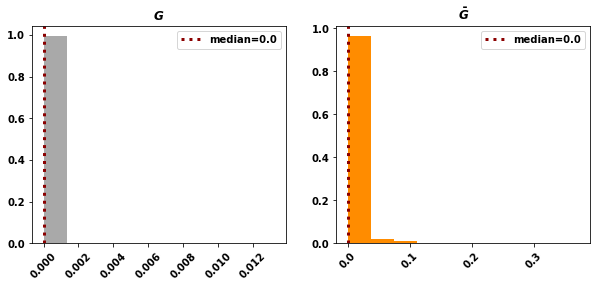

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
labels = [r'$G$', r'$\bar{G}$']


for i, measure in enumerate([distributions_betweeness, distributions_betweeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")

    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
    
    axes[i].set_title(labels[i])

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_betweeness_centralities.pdf", bbox_inches='tight')

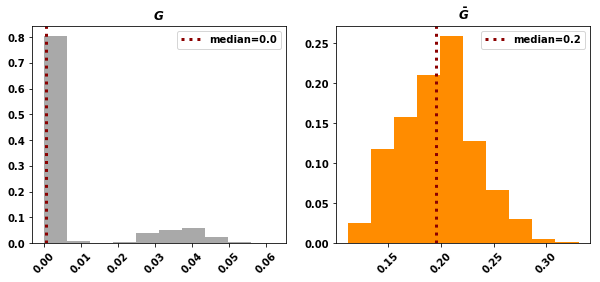

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, measure in enumerate([distributions_closeness,
                                  distributions_closeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(labels[i])
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_closeness_centralities.pdf", bbox_inches='tight')

Topics
=====

In [72]:
data_with_topics = pd.read_csv('../../data/prisoners_dilemma_meta_data_with_topics.csv')

In [73]:
names = df['author']

In [74]:
names = [tools.normalise_name(name) for name in names]

In [75]:
data_with_topics['author_standarized'] = names

**Graphs**

In [80]:
graphs = []
number_of_topics = 5
for number in range(number_of_topics):
    graphs.append(nx.read_gml(f'../../data/networks/topic_{int(number)}_pd_.gml'))

In [81]:
number_edges = [nx.number_of_edges(G) for G in graphs]
number_nodes = [nx.number_of_nodes(G) for G in graphs]

In [82]:
metrics = [collaborative_metrics_of_graph(G)[0] for G in graphs]

In [83]:
degree_dstrs = [collaborative_metrics_of_graph(G)[1] for G in graphs]

In [84]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]

In [85]:
topics = ["Topic A", "Topic B", "Topic C", "Topic D", "Topic E"]

In [86]:
metrics_table = pd.DataFrame.from_dict(metrics).round(3)
metrics_table.index = topics

In [87]:
metrics_table

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,Clustering coeff,# Communities,Modularity
Topic A,1193,2137,84,7.0,333,56,3.583,0.715,334,0.983
Topic B,727,1382,45,6.2,189,80,3.802,0.739,190,0.950
Topic C,931,1141,72,7.7,312,29,2.451,0.615,312,0.981
Topic D,891,1509,28,3.1,185,312,3.387,0.692,193,0.917
Topic E,1152,1964,166,14.4,461,31,3.410,0.602,461,0.926


In [88]:
metrics_table = metrics_table[columns_order]

In [89]:
write_to_file(metric=metrics_table.to_latex(), filename="topic_network_comparison.tex")

In [90]:
betweeness = [
    sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]



In [91]:
closeness = [
    sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]


In [92]:
tables = []
for measure in betweeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Betweeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [93]:
pd.concat(tables, axis=1)

,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness
1,David Rand,0.001393,Long Wang,0.005762,Daniel Ashlock,0.000612,Matjaz Perc,0.061972,Zengru Di,0.000079
2,Valerio Capraro,0.001112,Luo-Luo Jiang,0.004172,Matjaz Perc,0.000424,Luo-Luo Jiang,0.035731,Jian Yang,0.000027
3,Angel Sanchez,0.000492,Martin Nowak,0.003840,Karl Tuyls,0.000407,Yamir Moreno,0.030657,Yevgeniy Vorobeychik,0.000021
4,Feng Fu,0.000473,Matjaz Perc,0.003176,Philip Hingston,0.000306,Christoph Hauert,0.026775,Otavio Teixeira,0.000018
5,Martin Nowak,0.000430,Attila Szolnoki,0.002473,Eun-Youn Kim,0.000267,Long Wang,0.023491,Roberto Oliveira,0.000018
6,Nicholas Christakis,0.000311,Christian Hilbe,0.002158,Wendy Ashlock,0.000243,Zhen Wang,0.023361,M. Nowak,0.000017
7,Pablo Branas-Garza,0.000301,Yamir Moreno,0.002158,Attila Szolnoki,0.000211,Han-Xin Yang,0.022099,M. Harper,0.000009
8,Toshio Yamagishi,0.000270,Xiaojie Chen,0.001982,Seung Baek,0.000201,Martin Nowak,0.019261,Xiao Han,0.000009
9,James Fowler,0.000266,Arne Traulsen,0.001781,Martin Nowak,0.000197,Angel Sanchez,0.016495,Zhesi Shen,0.000009
10,Long Wang,0.000220,Zhen Wang,0.001664,Thore Graepel,0.000181,Zhihai Rong,0.015235,Wen-Xu Wang,0.000009


In [94]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="betweeness_topics_graphs.tex"
)

In [95]:
tables = []
for measure in closeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Closeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [96]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="closeness_topics_graphs.tex"
)

In [97]:
distributions_betweeness = [[point[1] for point in coeff] for coeff in betweeness]

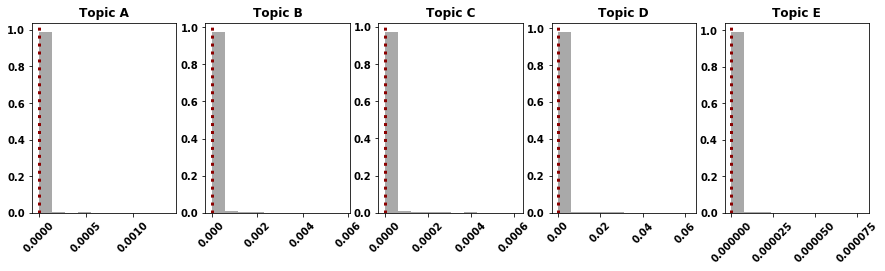

In [98]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3.5))

for i, measure in enumerate(distributions_betweeness):

    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[0])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(topics[i], fontweight='bold')
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.savefig("../../assets/images/topics_betweeness_distributions.pdf", bbox_inches="tight")

In [99]:
distributions_close = [[point[1] for point in coeff] for coeff in closeness]


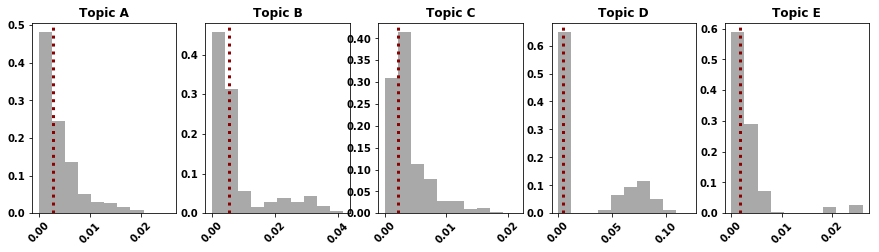

In [100]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3.5))

for i, measure in enumerate(distributions_close):

    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[0])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="darkred",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(topics[i], fontweight='bold')
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

plt.savefig("../../assets/images/topics_closeness_distributions.pdf", bbox_inches="tight")